In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/refcoco.pth
/kaggle/input/reference.txt
/kaggle/input/dinov2_vitl14_pretrain.pth
/kaggle/input/sam_vit_h_4b8939.pth
/kaggle/input/sample_image.jpg
/kaggle/input/swint_only_sam_many2many.pth
/kaggle/input/Images-20250418T060633Z-001/Images/backpack_dog/01.jpg
/kaggle/input/Images-20250418T060633Z-001/Images/backpack_dog/00.jpg
/kaggle/input/Images-20250418T060633Z-001/Images/clock/01.jpg
/kaggle/input/Images-20250418T060633Z-001/Images/clock/00.jpg
/kaggle/input/Images-20250418T060633Z-001/Images/can/01.jpg
/kaggle/input/Images-20250418T060633Z-001/Images/can/00.jpg
/kaggle/input/Images-20250418T060633Z-001/Images/berry_bowl/01.jpg
/kaggle/input/Images-20250418T060633Z-001/Images/berry_bowl/00.jpg
/kaggle/input/Images-20250418T060633Z-001/Images/candle/01.jpg
/kaggle/input/Images-20250418T060633Z-001/Images/candle/00.jpg
/kaggle/input/Images-20250418T060633Z-001/Images/barn/01.jpg
/kaggle/input/Images-20250418T060633Z-001/Images/barn/00.jpg
/kaggle/input/Images-20250418T06

In [2]:
!pip install ftfy packaging regex tqdm torch torchvision huggingface_hub safetensors timm open_clip_torch fairscale==0.4.4 pycocoevalcap requests filelock mmcv-full==1.3.12 mmsegmentation pycocotools==2.0.2 opencv-python==4.5.3.56

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 9.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 17.1 MB/s eta 0:00:00:00:010:01m
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a sub

In [3]:
!pip install h5py tokenizers==0.8.1rc1
# !pip install tokenizers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (tokenizers)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import requests
import torch.nn.functional as F

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# 4. Referring Image Segmentation (RIS)

In [7]:
references = {}

with open("/kaggle/input/reference.txt", "r") as f:
    references_text = f.readlines()

for line in references_text:
    image, desc = line.split(":")
    image, desc = image.strip(), desc.strip().strip('"')

    references[image] = desc

In [8]:
print(references)

{'ILSVRC2012_test_00000003.jpg': 'The walking dog in the picture', 'ILSVRC2012_test_00000004.jpg': 'The smiling dog in the grass', 'ILSVRC2012_test_00000018.jpg': 'The boy on left smiling and holding icecream', 'ILSVRC2012_test_00000019.jpg': 'The black gray bird on in the picture', 'ILSVRC2012_test_00000022.jpg': 'The sad dog standing beside the pool', 'ILSVRC2012_test_00000023.jpg': 'The guy in white shirt on the bicycle', 'ILSVRC2012_test_00000025.jpg': 'The butterfly in the picture', 'ILSVRC2012_test_00000026.jpg': 'The mang wearing a suite and tie', 'ILSVRC2012_test_00000030.jpg': 'The duck in the picture', 'ILSVRC2012_test_00000034.jpg': 'The white coffee cups on the coffee machine'}


In [9]:
!git clone https://github.com/yz93/LAVT-RIS.git

Cloning into 'LAVT-RIS'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 131 (delta 15), reused 12 (delta 12), pack-reused 107 (from 1)
Receiving objects: 100% (131/131), 6.92 MiB | 34.71 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [10]:
%cd LAVT-RIS

/kaggle/working/LAVT-RIS


In [11]:
!pip install mmcv-full==1.3.12

  Using cached mmcv-full-1.3.12.tar.gz (309 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 14.8 MB/s eta 0:00:00
  Created wheel for mmcv-full: filename=mmcv_full-1.3.12-cp311-cp311-linux_x86_64.whl size=49584757 sha256=dfd3dffad7c957c3e9ae42685ebb4b2b3effb8955e369d199baa98cf1afb34f7
  Stored in directory: /root/.cache/pip/wheels/90/56/70/f24e39411b988b09c1fe7388763d5471b13fa53518182093fb
Successfully built mmcv-full


In [12]:
!pip install mmsegmentation==0.17.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.2/542.2 kB 18.0 MB/s eta 0:00:00


In [13]:
!pip install pycocotools==2.0.2

  Using cached pycocotools-2.0.2.tar.gz (23 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pycocotools
  Running setup.py clean for pycocotools
Failed to build pycocotools
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pycocotools)


In [ ]:
# ## REFERENCE: LAVT-RIS Github
# ## demo_inference.py

# image_path = './demo/demo.jpg'
# sentence = 'the most handsome guy'
# weights = './checkpoints/refcoco.pth'
# device = 'cuda:0'

# # pre-process the input image
# from PIL import Image
# import torchvision.transforms as T
# import numpy as np
# img = Image.open(image_path).convert("RGB")
# img_ndarray = np.array(img)  # (orig_h, orig_w, 3); for visualization
# original_w, original_h = img.size  # PIL .size returns width first and height second

# image_transforms = T.Compose(
#     [
#      T.Resize(480),
#      T.ToTensor(),
#      T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ]
# )

# img = image_transforms(img).unsqueeze(0)  # (1, 3, 480, 480)
# img = img.to(device)  # for inference (input)

# # pre-process the raw sentence
# from bert.tokenization_bert import BertTokenizer
# import torch
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# sentence_tokenized = tokenizer.encode(text=sentence, add_special_tokens=True)
# sentence_tokenized = sentence_tokenized[:20]  # if the sentence is longer than 20, then this truncates it to 20 words
# # pad the tokenized sentence
# padded_sent_toks = [0] * 20
# padded_sent_toks[:len(sentence_tokenized)] = sentence_tokenized
# # create a sentence token mask: 1 for real words; 0 for padded tokens
# attention_mask = [0] * 20
# attention_mask[:len(sentence_tokenized)] = [1]*len(sentence_tokenized)
# # convert lists to tensors
# padded_sent_toks = torch.tensor(padded_sent_toks).unsqueeze(0)  # (1, 20)
# attention_mask = torch.tensor(attention_mask).unsqueeze(0)  # (1, 20)
# padded_sent_toks = padded_sent_toks.to(device)  # for inference (input)
# attention_mask = attention_mask.to(device)  # for inference (input)

# # initialize model and load weights
# from bert.modeling_bert import BertModel
# from lib import segmentation

# # construct a mini args class; like from a config file


# class args:
#     swin_type = 'base'
#     window12 = True
#     mha = ''
#     fusion_drop = 0.0


# single_model = segmentation.__dict__['lavt'](pretrained='', args=args)
# single_model.to(device)
# model_class = BertModel
# single_bert_model = model_class.from_pretrained('bert-base-uncased')
# single_bert_model.pooler = None

# checkpoint = torch.load(weights, map_location='cpu')
# single_bert_model.load_state_dict(checkpoint['bert_model'])
# single_model.load_state_dict(checkpoint['model'])
# model = single_model.to(device)
# bert_model = single_bert_model.to(device)


# # inference
# import torch.nn.functional as F
# last_hidden_states = bert_model(padded_sent_toks, attention_mask=attention_mask)[0]
# embedding = last_hidden_states.permute(0, 2, 1)
# output = model(img, embedding, l_mask=attention_mask.unsqueeze(-1))
# output = output.argmax(1, keepdim=True)  # (1, 1, 480, 480)
# output = F.interpolate(output.float(), (original_h, original_w))  # 'nearest'; resize to the original image size
# output = output.squeeze()  # (orig_h, orig_w)
# output = output.cpu().data.numpy()  # (orig_h, orig_w)


# # show/save results
# def overlay_davis(image, mask, colors=[[0, 0, 0], [255, 0, 0]], cscale=1, alpha=0.4):
#     from scipy.ndimage.morphology import binary_dilation

#     colors = np.reshape(colors, (-1, 3))
#     colors = np.atleast_2d(colors) * cscale

#     im_overlay = image.copy()
#     object_ids = np.unique(mask)

#     for object_id in object_ids[1:]:
#         # Overlay color on  binary mask
#         foreground = image*alpha + np.ones(image.shape)*(1-alpha) * np.array(colors[object_id])
#         binary_mask = mask == object_id

#         # Compose image
#         im_overlay[binary_mask] = foreground[binary_mask]

#         # countours = skimage.morphology.binary.binary_dilation(binary_mask) - binary_mask
#         countours = binary_dilation(binary_mask) ^ binary_mask
#         # countours = cv2.dilate(binary_mask, cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))) - binary_mask
#         im_overlay[countours, :] = 0

#     return im_overlay.astype(image.dtype)


# output = output.astype(np.uint8)  # (orig_h, orig_w), np.uint8
# # Overlay the mask on the image
# visualization = overlay_davis(img_ndarray, output)  # red
# visualization = Image.fromarray(visualization)
# # show the visualization
# #visualization.show()
# # Save the visualization
# visualization.save('./demo/demo_result.jpg')

In [14]:
from PIL import Image
import torchvision.transforms as T
import numpy as np
from bert.tokenization_bert import BertTokenizer
import torch
# from scipy.ndimage.morphology import binary_dilation
from scipy.ndimage import binary_dilation

samples_dir = "/kaggle/input/samples-20250417T083449Z-001/samples/"

In [72]:
!find . -name "refcoco.pth"

In [15]:
from bert.modeling_bert import BertModel
from lib import segmentation

weights = '/kaggle/input/refcoco.pth'

class args:
    swin_type = 'base'
    window12 = True
    mha = ''
    fusion_drop = 0.0


single_model = segmentation.__dict__['lavt'](pretrained='', args=args)
single_model.to(device)
model_class = BertModel
single_bert_model = model_class.from_pretrained('bert-base-uncased')
single_bert_model.pooler = None

checkpoint = torch.load(weights, map_location='cpu')
single_bert_model.load_state_dict(checkpoint['bert_model'])
single_model.load_state_dict(checkpoint['model'])
model = single_model.to(device)
bert_model = single_bert_model.to(device)

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


Window size 12!


/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Randomly initialize Multi-modal Swin Transformer weights.


Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

/kaggle/working/LAVT-RIS/bert/modeling_utils.py:676: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(resolved_archive_file, map_location="cpu")
/tmp/ip

In [16]:
segmented_samples = {}
y1_features = {}

for filename in os.listdir(samples_dir):
    image_path = os.path.join(samples_dir, filename)
    sentence = references[filename]


    img = Image.open(image_path).convert("RGB")
    img_ndarray = np.array(img)
    original_w, original_h = img.size
    
    image_transforms = T.Compose(
        [
         T.Resize(480),
         T.ToTensor(),
         T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]
    )
    
    img = image_transforms(img).unsqueeze(0)
    img = img.to(device)
    
    
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    sentence_tokenized = tokenizer.encode(text=sentence, add_special_tokens=True)
    sentence_tokenized = sentence_tokenized[:20]

    padded_sent_toks = [0] * 20
    padded_sent_toks[:len(sentence_tokenized)] = sentence_tokenized

    attention_mask = [0] * 20
    attention_mask[:len(sentence_tokenized)] = [1]*len(sentence_tokenized)

    padded_sent_toks = torch.tensor(padded_sent_toks).unsqueeze(0)
    attention_mask = torch.tensor(attention_mask).unsqueeze(0)
    padded_sent_toks = padded_sent_toks.to(device)
    attention_mask = attention_mask.to(device)

    import torch.nn.functional as F
    last_hidden_states = bert_model(padded_sent_toks, attention_mask=attention_mask)[0]
    embedding = last_hidden_states.permute(0, 2, 1)
    output = model(img, embedding, l_mask=attention_mask.unsqueeze(-1))
    y1_features[filename] = output
    output = output.argmax(1, keepdim=True)
    output = F.interpolate(output.float(), (original_h, original_w))
    output = output.squeeze()
    output = output.cpu().data.numpy()


    def overlay_davis(image, mask, colors=[[0, 0, 0], [255, 0, 0]], cscale=1, alpha=0.4):
        colors = np.reshape(colors, (-1, 3))
        colors = np.atleast_2d(colors) * cscale
    
        im_overlay = image.copy()
        object_ids = np.unique(mask)
    
        for object_id in object_ids[1:]:
            foreground = image*alpha + np.ones(image.shape)*(1-alpha) * np.array(colors[object_id])
            binary_mask = mask == object_id
    
            im_overlay[binary_mask] = foreground[binary_mask]
    
            countours = binary_dilation(binary_mask) ^ binary_mask
            im_overlay[countours, :] = 0
    
        return im_overlay.astype(image.dtype)
    
    
    output = output.astype(np.uint8)

    visualization = overlay_davis(img_ndarray, output)
    visualization = Image.fromarray(visualization)
    visualization.save('../' + filename)

    segmented_samples[filename] = visualization
    print(filename, "saved")

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

ILSVRC2012_test_00000004.jpg saved
ILSVRC2012_test_00000022.jpg saved
ILSVRC2012_test_00000023.jpg saved
ILSVRC2012_test_00000026.jpg saved
ILSVRC2012_test_00000018.jpg saved
ILSVRC2012_test_00000003.jpg saved
ILSVRC2012_test_00000019.jpg saved
ILSVRC2012_test_00000030.jpg saved
ILSVRC2012_test_00000034.jpg saved
ILSVRC2012_test_00000025.jpg saved


ILSVRC2012_test_00000004.jpg : The smiling dog in the grass


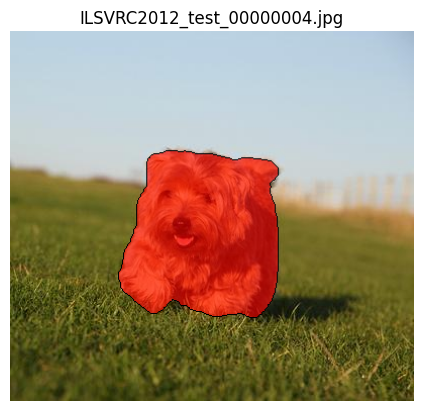

ILSVRC2012_test_00000022.jpg : The sad dog standing beside the pool


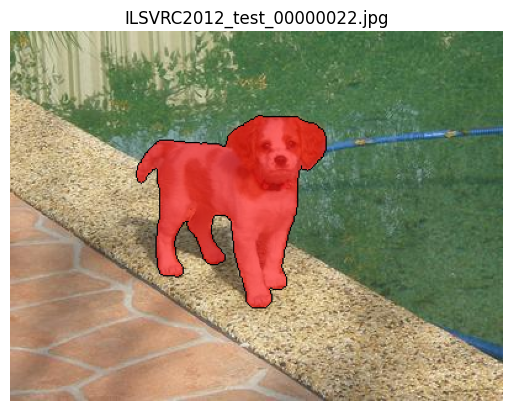

ILSVRC2012_test_00000023.jpg : The guy in white shirt on the bicycle


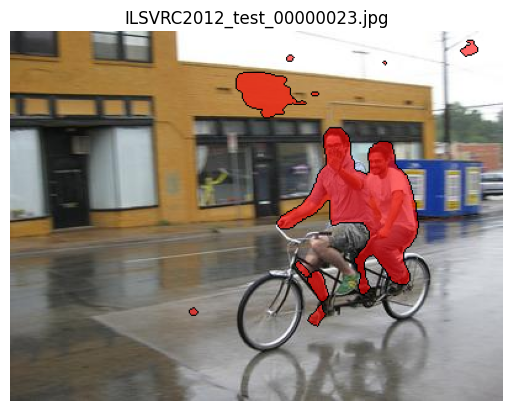

ILSVRC2012_test_00000026.jpg : The mang wearing a suite and tie


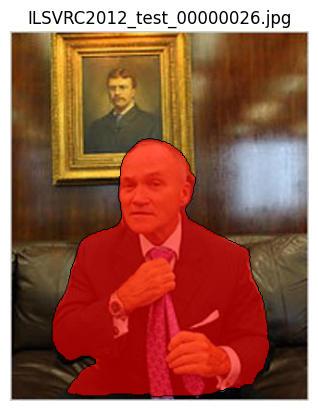

ILSVRC2012_test_00000018.jpg : The boy on left smiling and holding icecream


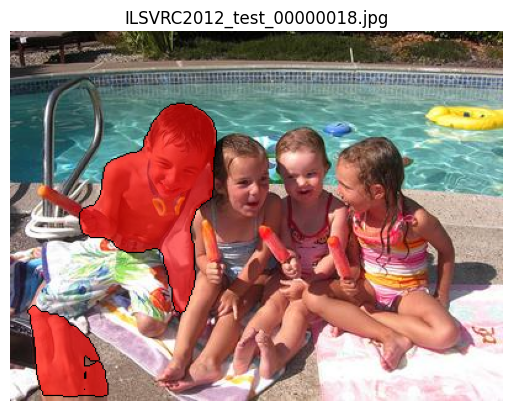

ILSVRC2012_test_00000003.jpg : The walking dog in the picture


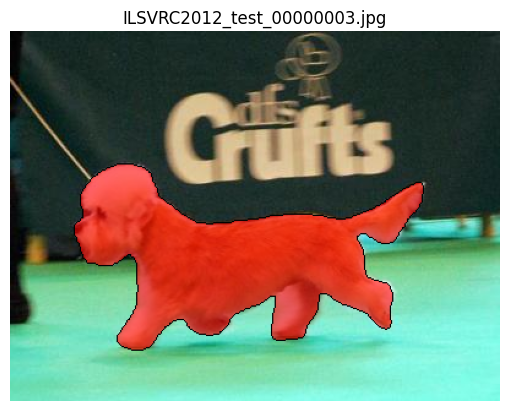

ILSVRC2012_test_00000019.jpg : The black gray bird on in the picture


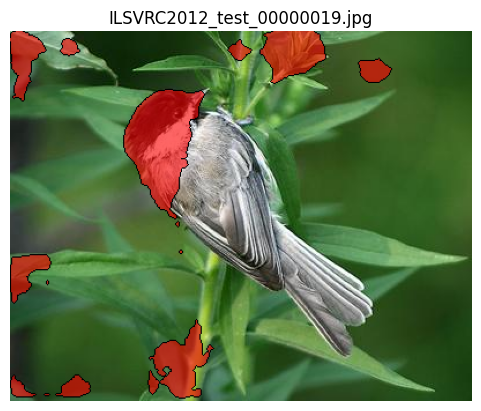

ILSVRC2012_test_00000030.jpg : The duck in the picture


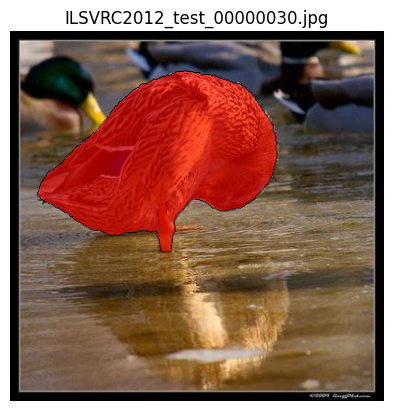

ILSVRC2012_test_00000034.jpg : The white coffee cups on the coffee machine


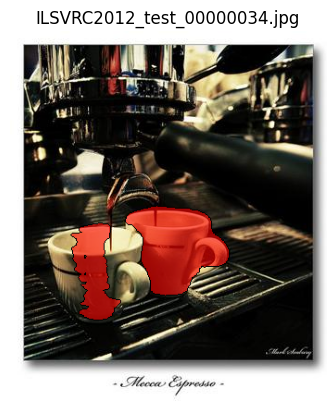

ILSVRC2012_test_00000025.jpg : The butterfly in the picture


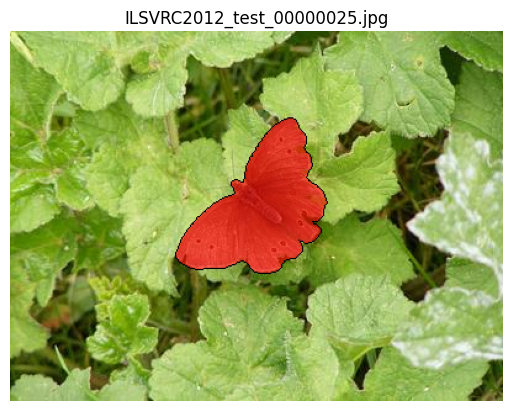

In [17]:
for filename in os.listdir(samples_dir):
    print(filename, ":", references[filename])
    plt.imshow(segmented_samples[filename])
    plt.axis("off")
    plt.title(filename)
    plt.show()

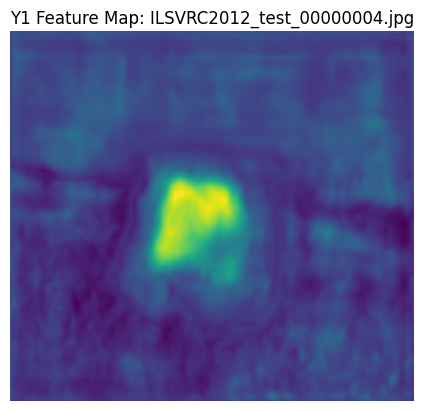

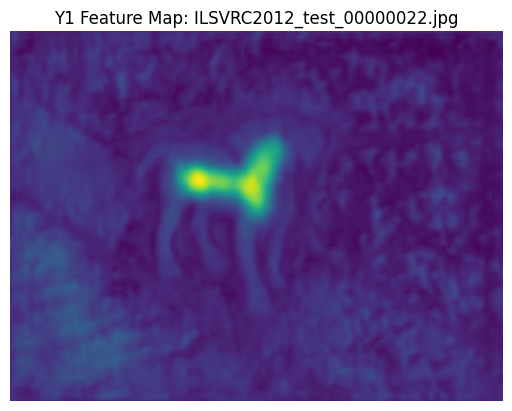

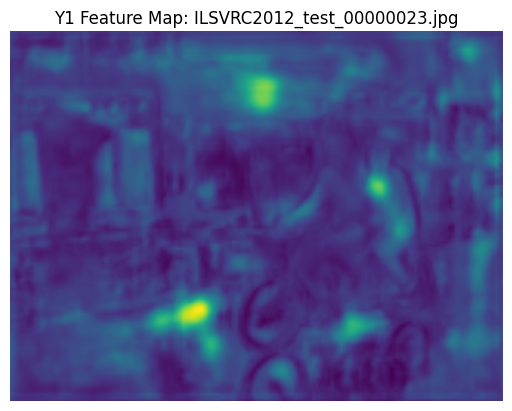

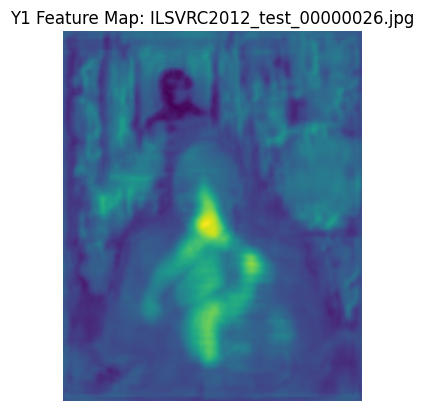

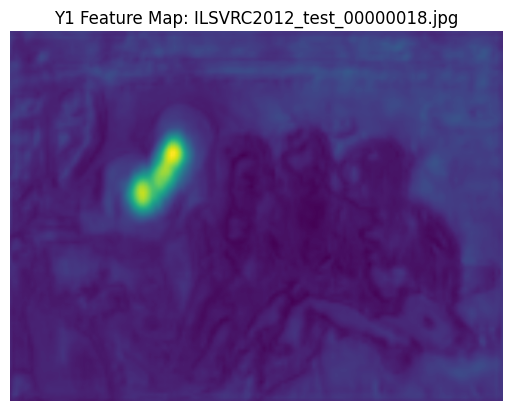

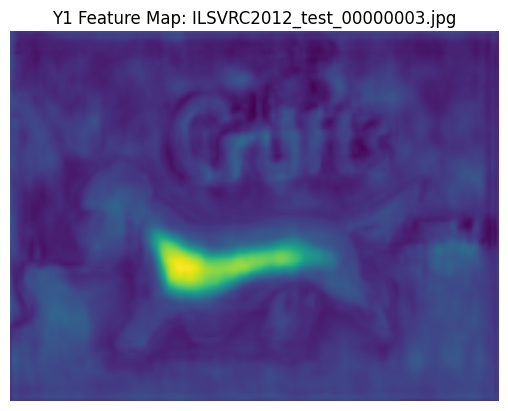

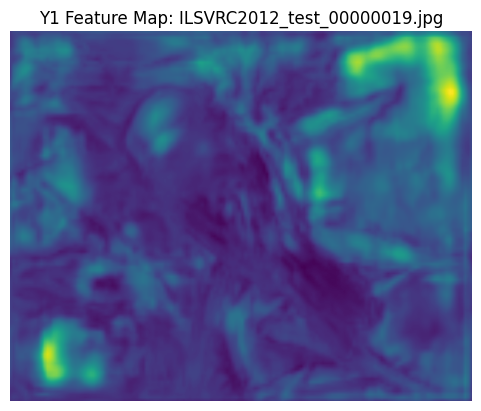

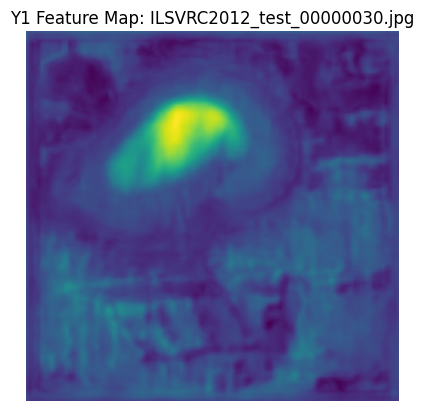

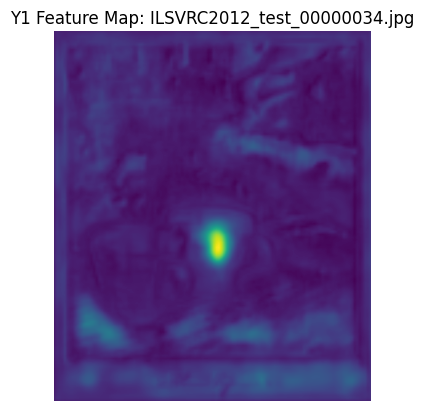

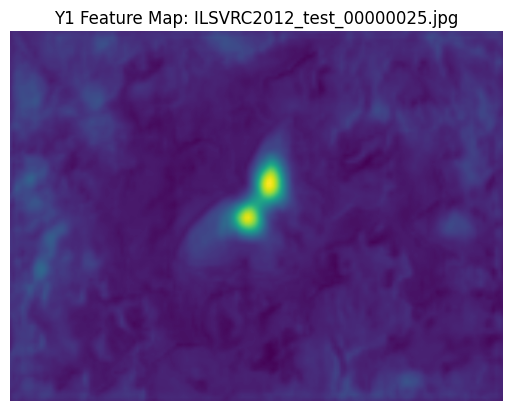

In [18]:
for filename in os.listdir(samples_dir):
    cur_y1_fm = y1_features[filename].squeeze(0).mean(dim=0)

    plt.imshow(cur_y1_fm.cpu().detach().numpy(), cmap="viridis")
    plt.title("Y1 Feature Map: " + filename)
    plt.axis("off")
    plt.show()

In [19]:
fail_references = {
    'ILSVRC2012_test_00000004.jpg' : "the black eyes of the dog",
    'ILSVRC2012_test_00000022.jpg' : "the brown marble floor in the picture",
    'ILSVRC2012_test_00000023.jpg' : "the blue dustbin in the picture",
    'ILSVRC2012_test_00000026.jpg' : "the brown hair in the painting",
    'ILSVRC2012_test_00000018.jpg' : "the red icecream in the children's hands",
    'ILSVRC2012_test_00000003.jpg' : "the golden logo in the picture",
    'ILSVRC2012_test_00000019.jpg' : "the green plant in the picture",
    'ILSVRC2012_test_00000030.jpg' : "the yellow beak of the duck",
    'ILSVRC2012_test_00000034.jpg' : "the black handle of the coffee machine",
    'ILSVRC2012_test_00000025.jpg' : "the green leaves just below the butterfly"
}

In [20]:
fail_segmented_samples = {}

for filename in os.listdir(samples_dir):
    image_path = os.path.join(samples_dir, filename)
    sentence = fail_references[filename]


    img = Image.open(image_path).convert("RGB")
    img_ndarray = np.array(img)
    original_w, original_h = img.size
    
    image_transforms = T.Compose(
        [
         T.Resize(480),
         T.ToTensor(),
         T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]
    )
    
    img = image_transforms(img).unsqueeze(0)
    img = img.to(device)
    
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    sentence_tokenized = tokenizer.encode(text=sentence, add_special_tokens=True)
    sentence_tokenized = sentence_tokenized[:20]
    
    padded_sent_toks = [0] * 20
    padded_sent_toks[:len(sentence_tokenized)] = sentence_tokenized

    attention_mask = [0] * 20
    attention_mask[:len(sentence_tokenized)] = [1]*len(sentence_tokenized)

    padded_sent_toks = torch.tensor(padded_sent_toks).unsqueeze(0)
    attention_mask = torch.tensor(attention_mask).unsqueeze(0)
    padded_sent_toks = padded_sent_toks.to(device)
    attention_mask = attention_mask.to(device)

    import torch.nn.functional as F
    last_hidden_states = bert_model(padded_sent_toks, attention_mask=attention_mask)[0]
    embedding = last_hidden_states.permute(0, 2, 1)
    output = model(img, embedding, l_mask=attention_mask.unsqueeze(-1))
    output = output.argmax(1, keepdim=True)
    output = F.interpolate(output.float(), (original_h, original_w))
    output = output.squeeze()
    output = output.cpu().data.numpy()

    def overlay_davis(image, mask, colors=[[0, 0, 0], [255, 0, 0]], cscale=1, alpha=0.4):
        colors = np.reshape(colors, (-1, 3))
        colors = np.atleast_2d(colors) * cscale
    
        im_overlay = image.copy()
        object_ids = np.unique(mask)
    
        for object_id in object_ids[1:]:
            foreground = image*alpha + np.ones(image.shape)*(1-alpha) * np.array(colors[object_id])
            binary_mask = mask == object_id
    
            im_overlay[binary_mask] = foreground[binary_mask]
    
            countours = binary_dilation(binary_mask) ^ binary_mask
            im_overlay[countours, :] = 0
    
        return im_overlay.astype(image.dtype)
    
    
    output = output.astype(np.uint8)
    
    visualization = overlay_davis(img_ndarray, output)
    visualization = Image.fromarray(visualization)
    visualization.save('../f_' + filename)

    fail_segmented_samples[filename] = visualization
    print(filename, "saved")

ILSVRC2012_test_00000004.jpg saved
ILSVRC2012_test_00000022.jpg saved
ILSVRC2012_test_00000023.jpg saved
ILSVRC2012_test_00000026.jpg saved
ILSVRC2012_test_00000018.jpg saved
ILSVRC2012_test_00000003.jpg saved
ILSVRC2012_test_00000019.jpg saved
ILSVRC2012_test_00000030.jpg saved
ILSVRC2012_test_00000034.jpg saved
ILSVRC2012_test_00000025.jpg saved


ILSVRC2012_test_00000004.jpg : the black eyes of the dog


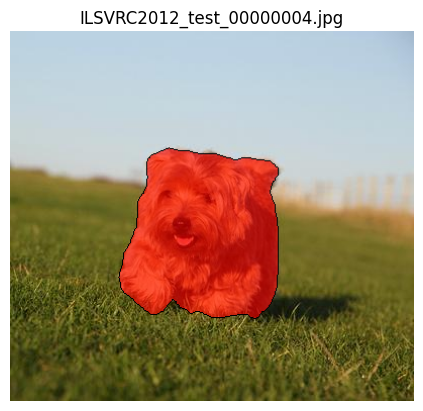

ILSVRC2012_test_00000022.jpg : the brown marble floor in the picture


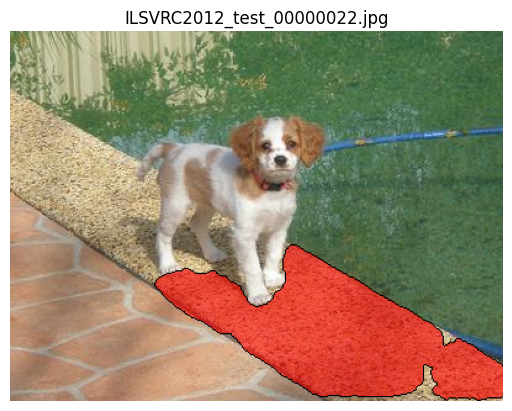

ILSVRC2012_test_00000023.jpg : the blue dustbin in the picture


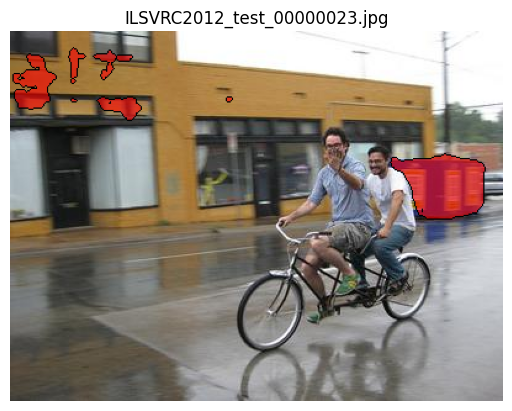

ILSVRC2012_test_00000026.jpg : the brown hair in the painting


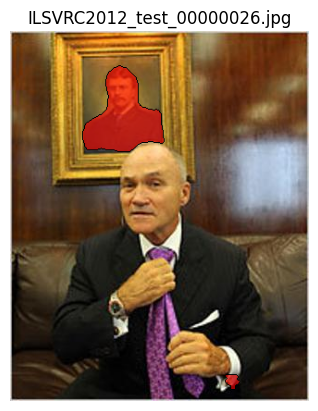

ILSVRC2012_test_00000018.jpg : the red icecream in the children's hands


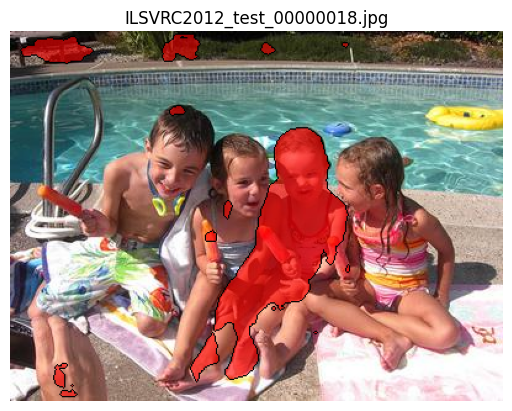

ILSVRC2012_test_00000003.jpg : the golden logo in the picture


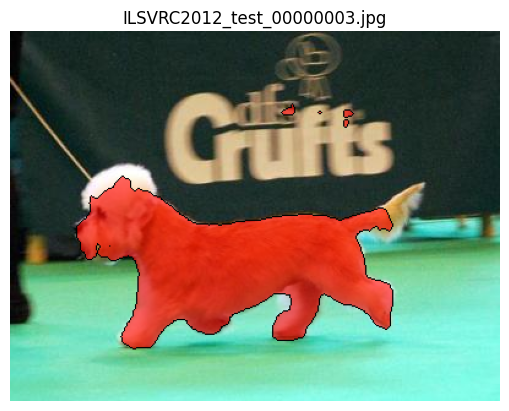

ILSVRC2012_test_00000019.jpg : the green plant in the picture


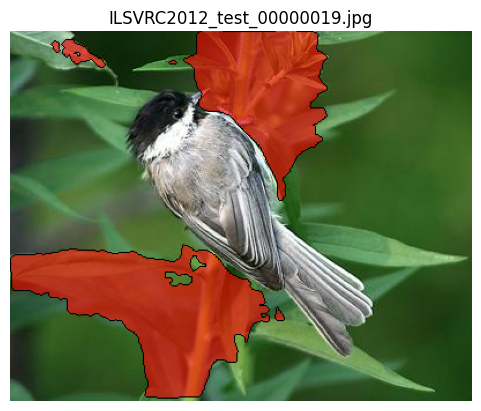

ILSVRC2012_test_00000030.jpg : the yellow beak of the duck


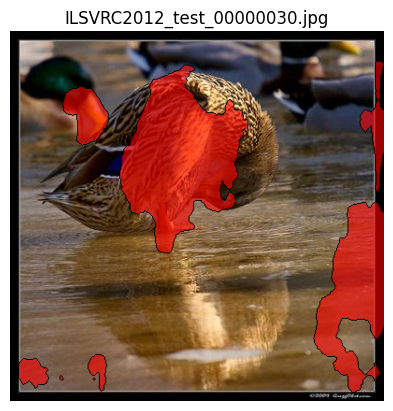

ILSVRC2012_test_00000034.jpg : the black handle of the coffee machine


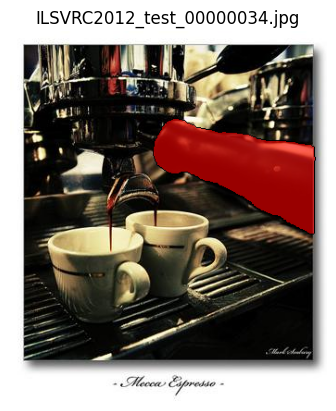

ILSVRC2012_test_00000025.jpg : the green leaves just below the butterfly


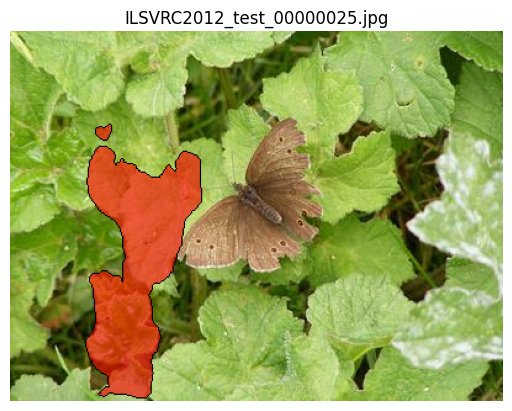

In [21]:
for filename in os.listdir(samples_dir):
    print(filename, ":", fail_references[filename])
    plt.imshow(fail_segmented_samples[filename])
    plt.axis("off")
    plt.title(filename)
    plt.show()